In [53]:
import pandas as pd # type: ignore
import numpy as np # type: ignore

In [54]:
# Import the FoodDemandForecaster class
from forecaster import FoodDemandForecaster

# Create an instance of the forecaster
forecaster = FoodDemandForecaster()

# Load the data (this will automatically call preprocess_data() which includes region mapping and meal filtering)
forecaster.load_data()

# If you want to view the regional mapping after it's been created
print("\nRegional Mapping:")
for center_id, region in forecaster.regional_mapping.items():
    print(f"Center ID {center_id} -> {region}")

# Check the dataset before and after filtering
# The original dataset should be in forecaster.train_data
print("\nData shape after filtering:")
print(f"Train data shape: {forecaster.train_data.shape}")
print(f"Unique meal IDs remaining: {len(forecaster.train_data['meal_id'].unique())}")

# You can also access the filtered meal IDs that were removed
removed_meals = [1571, 2104, 2956, 2490, 2569, 2664]
print(f"\nMeals filtered out: {removed_meals}")

# To see data availability analysis results
print("\nData Availability Analysis:")
for key, info in list(forecaster.data_availability.items())[:5]:  # Show first 5 items
    print(f"{key}: {info['records']} records, {info['weeks']} weeks, Sufficient: {info['sufficient']}")

🍽️ Loaded 45 meal names from meal_database.json
   • 1885: Basic Vegetable Pasta Bake
   • 1993: Simple Spinach and Chickpea Curry
   • 2539: Basic Tofu Stir Fry
   • ... and 42 more
✅ Loaded train.csv: 456548 records
📋 Train columns: ['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured', 'num_orders']
ℹ️ test.csv not found - continuing without it (not required for forecasting)
🍽️ Filtering meals with insufficient coverage...
📊 Initial meals: 51 total
📊 Initial records: 456,548
🗑️ Removing meals: [1571, 2104, 2956, 2490, 2569, 2664]
✅ Filtering complete:
   • Meals removed: 6
   • Records removed: 38,746
   • Remaining meals: 45
   • Remaining records: 417,802
   • Data reduction: 8.5%
📍 Loading regional mapping from fulfilment_center_info.csv
📋 Fulfilment center data loaded: 77 centers
📋 Columns: ['center_id', 'city_code', 'region_code', 'center_type', 'op_area']
🗺️ Regional mapping created from fulfilment center info:
   R

KeyError: 'records'

In [55]:
# remove Lyon
forecaster.train_data = forecaster.train_data.loc[forecaster.train_data['region'] != "Region-Lyon"]

In [56]:
forecaster.train_data.drop(columns=['emailer_for_promotion', 'homepage_featured', 'base_price'], inplace=True)

In [57]:
print("Data Points in Total by region:")
forecaster.train_data['region'].value_counts()

Data Points in Total by region:


region
Region-Kassel    176117
Region-Luzern    105864
Region-Wien       86302
Name: count, dtype: int64

In [58]:
# Average per Region
regions = ['Region-Kassel', "Region-Luzern", "Region-Wien"]
for region in regions:
    len(forecaster.train_data[forecaster.train_data['region'] == region]) / 145
    print(f"Average data points per week in {region}: {len(forecaster.train_data[forecaster.train_data['region'] == region]) / 145:.2f}")

Average data points per week in Region-Kassel: 1214.60
Average data points per week in Region-Luzern: 730.10
Average data points per week in Region-Wien: 595.19


In [59]:
for region in regions:
    print(f"Average number of meals per week in {region}: {forecaster.train_data['num_orders'][forecaster.train_data['region'] == region].sum() / 145:.2f}")

Average number of meals per week in Region-Kassel: 381516.63
Average number of meals per week in Region-Luzern: 146010.45
Average number of meals per week in Region-Wien: 124915.57


In [60]:
for region in regions:
    region_data = forecaster.train_data[forecaster.train_data['region'] == region]
    # Calculate revenue per record
    region_data['revenue'] = region_data['num_orders'] * region_data['checkout_price']
    
    # Calculate total meals sold for this region
    total_meals_sold = region_data['num_orders'].sum()
    
    # Group by week and calculate various metrics
    weekly_stats = region_data.groupby('week').agg({
        'revenue': 'sum',
        'num_orders': 'sum'  # Sum the number of orders per week
    }).reset_index()
    
    # Calculate statistics
    total_weeks = weekly_stats['week'].nunique()
    total_revenue = weekly_stats['revenue'].sum()
    mean_revenue = weekly_stats['revenue'].mean()
    mean_meals_per_week = weekly_stats['num_orders'].mean()
    
    # Format numbers with thousands separator (European style)
    total_revenue_formatted = f"{total_revenue:,.2f}"
    mean_revenue_formatted = f"{mean_revenue:,.2f}"
    total_meals_formatted = f"{total_meals_sold:,}"
    mean_meals_formatted = f"{mean_meals_per_week:,.2f}"
    
    print(f"Region: {region}")
    print(f"  - Total weeks with data: {total_weeks}")
    print(f"  - Total revenue: {total_revenue_formatted} EUR")
    print(f"  - Average revenue per week: {mean_revenue_formatted} EUR")
    print(f"  - Total meals sold: {total_meals_formatted}")
    print(f"  - Average meals sold per week: {mean_meals_formatted}")

Region: Region-Kassel
  - Total weeks with data: 145
  - Total revenue: 14,277,983,431.71 EUR
  - Average revenue per week: 98,468,851.25 EUR
  - Total meals sold: 55,319,911
  - Average meals sold per week: 381,516.63
Region: Region-Luzern
  - Total weeks with data: 145
  - Total revenue: 5,788,937,305.94 EUR
  - Average revenue per week: 39,923,705.56 EUR
  - Total meals sold: 21,171,515
  - Average meals sold per week: 146,010.45
Region: Region-Wien
  - Total weeks with data: 145
  - Total revenue: 4,847,332,717.01 EUR
  - Average revenue per week: 33,429,880.81 EUR
  - Total meals sold: 18,112,757
  - Average meals sold per week: 124,915.57


In [61]:
forecaster.train_data

,id,week,center_id,meal_id,checkout_price,num_orders,region
0,1379560,1,55,1885,136.83,177,Region-Kassel
1,1466964,1,55,1993,136.83,270,Region-Kassel
2,1346989,1,55,2539,134.86,189,Region-Kassel
3,1338232,1,55,2139,339.50,54,Region-Kassel
4,1448490,1,55,2631,243.50,40,Region-Kassel
...,...,...,...,...,...,...,...
456540,1035758,145,61,1525,319.13,134,Region-Wien
456541,1010438,145,61,2704,321.13,67,Region-Wien
456542,1116711,145,61,2492,455.93,42,Region-Wien
456543,1271326,145,61,1543,484.09,68,Region-Wien


In [62]:
import pandas as pd
import json

# Load the meal database from JSON file
with open('meal_database.json', 'r') as file:
    meal_data = json.load(file)

# Create a list to store the meal information
meals_list = []

# Extract data from the JSON structure
for meal_id, details in meal_data.items():
    # Calculate average ingredient weight
    avg_ingredient_weight = sum(details['kg_per_10_persons']) / len(details['kg_per_10_persons'])
    
    # Calculate perishability ratio (percentage of perishable ingredients)
    perishability = sum(details['perishable']) / len(details['perishable']) * 100
    
    # Create a dictionary for this meal
    meal_info = {
        'meal_id': int(meal_id),
        'name': details['name'],
    }
    
    meals_list.append(meal_info)

# Create DataFrame
meals_df = pd.DataFrame(meals_list)

# Sort by meal_id for better readability
meals_df = meals_df.sort_values('meal_id').reset_index(drop=True)

# Display the DataFrame
print(f"Loaded {len(meals_df)} meals from the database")
meals_df.head(20)

Loaded 45 meals from the database


,meal_id,name
0,1062,Beef Goulash
1,1109,Wild Mushroom Risotto
2,1198,Vegetable Stir Fry
3,1207,Authentic Carbonara
4,1216,Gourmet Curry Selection
5,1230,Teriyaki Salmon Bowl
6,1247,Gourmet Chicken Alfredo
7,1248,Simple Swedish Meatballs
8,1311,Fish Tacos
9,1438,Beef Burgers


In [63]:
import json

# Load the meal database from JSON file
with open('meal_database.json', 'r') as file:
    meal_data = json.load(file)

# Create a list to store the ingredients information
ingredients_list = []

# Extract ingredient data from each meal
for meal_id, details in meal_data.items():
    for i, ingredient in enumerate(details['ingredients']):
        # Get the corresponding data for this ingredient
        kg_per_10 = details['kg_per_10_persons'][i]
        price_pct = details['price_distribution'][i]
        is_perishable = details['perishable'][i]
        storage_m3 = details['storage_m3'][i]  # Adding the storage volume data
        
        # Create a record for this ingredient
        ingredient_info = {
            'meal_id': int(meal_id),
            'meal_name': details['name'],
            'ingredient': ingredient,
            'kg_per_10_persons': kg_per_10,
            'price_percentage': price_pct,
            'is_perishable': is_perishable,
            'storage_m3': storage_m3  # Including storage volume in the dictionary
        }
        
        ingredients_list.append(ingredient_info)

# Create DataFrame
ingredients_df = pd.DataFrame(ingredients_list)

# Display information about the DataFrame
print(f"Created ingredients DataFrame with {len(ingredients_df)} records")
print(f"Number of unique ingredients: {ingredients_df['ingredient'].nunique()}")
print(f"Number of meals: {ingredients_df['meal_id'].nunique()}")

# Show the first few rows with the new storage_m3 column
ingredients_df.head()

Created ingredients DataFrame with 225 records
Number of unique ingredients: 202
Number of meals: 45


,meal_id,meal_name,ingredient,kg_per_10_persons,price_percentage,is_perishable,storage_m3
0,1885,Basic Vegetable Pasta Bake,Pasta,2.00,30,False,0.0050
1,1885,Basic Vegetable Pasta Bake,Fresh mixed vegetables,1.50,40,True,0.0080
2,1885,Basic Vegetable Pasta Bake,Powdered cheese sauce mix,0.20,20,False,0.0005
3,1885,Basic Vegetable Pasta Bake,Dried herb blend,0.05,5,False,0.0001
4,1885,Basic Vegetable Pasta Bake,Breadcrumb topping,0.20,5,False,0.0006


In [64]:
ingredients_df.loc[ingredients_df['meal_id'] == 1778]

,meal_id,meal_name,ingredient,kg_per_10_persons,price_percentage,is_perishable,storage_m3
35,1778,Chicken Curry,Chicken pieces,2.00,55,True,0.0040
36,1778,Chicken Curry,Curry sauce,1.00,15,True,0.0015
37,1778,Chicken Curry,Basmati rice,2.00,15,False,0.0040
38,1778,Chicken Curry,Naan bread,0.70,12,True,0.0025
39,1778,Chicken Curry,Fresh herbs,0.05,3,True,0.0003


In [65]:
import pandas as pd
import json

# Load the meal database from JSON file
with open('meal_database.json', 'r') as file:
    meal_data = json.load(file)

# Create a list to store the meal information
meals_list = []

# Extract data from the JSON structure
for meal_id, details in meal_data.items():
    # Skip entries without complete data
    if 'name' not in details or 'perishable' not in details:
        continue
        
    # Calculate average ingredient weight
    avg_ingredient_weight = sum(details['kg_per_10_persons']) / len(details['kg_per_10_persons'])
    
    # Calculate perishability ratio (percentage of perishable ingredients)
    perishability = sum(details['perishable']) / len(details['perishable']) * 100
    
    # Create a dictionary for this meal
    meal_info = {
        'meal_id': int(meal_id),
        'name': details['name'],
    }
    
    meals_list.append(meal_info)

# Create DataFrame
meals_df = pd.DataFrame(meals_list)

# Sort by meal_id for better readability
meals_df = meals_df.sort_values('meal_id').reset_index(drop=True)

# Now calculate storage requirements based on ingredients
# Initialize storage columns with zeros
meals_df['storage_cool'] = 0.0
meals_df['storage_warehouse'] = 0.0

# For each meal, aggregate storage requirements from ingredients
for meal_id in meals_df['meal_id']:
    # Get all ingredients for this meal
    meal_ingredients = ingredients_df[ingredients_df['meal_id'] == meal_id]
    
    # Sum storage for perishable ingredients (cool storage)
    cool_storage = meal_ingredients[meal_ingredients['is_perishable']]['storage_m3'].sum()
    
    # Sum storage for non-perishable ingredients (warehouse storage)
    warehouse_storage = meal_ingredients[~meal_ingredients['is_perishable']]['storage_m3'].sum()
    
    # Update the meals dataframe
    meals_df.loc[meals_df['meal_id'] == meal_id, 'storage_cool'] = cool_storage
    meals_df.loc[meals_df['meal_id'] == meal_id, 'storage_warehouse'] = warehouse_storage

# Display the DataFrame
print(f"Loaded {len(meals_df)} meals from the database")
# Format storage columns to 4 decimal places for better readability
meals_df['storage_cool'] = meals_df['storage_cool'].round(4)
meals_df['storage_warehouse'] = meals_df['storage_warehouse'].round(4)
meals_df.head(20)

Loaded 45 meals from the database


,meal_id,name,storage_cool,storage_warehouse
0,1062,Beef Goulash,0.0152,0.0000
1,1109,Wild Mushroom Risotto,0.0071,0.0041
2,1198,Vegetable Stir Fry,0.0126,0.0031
3,1207,Authentic Carbonara,0.0083,0.0000
4,1216,Gourmet Curry Selection,0.0155,0.0044
5,1230,Teriyaki Salmon Bowl,0.0097,0.0041
6,1247,Gourmet Chicken Alfredo,0.0170,0.0000
7,1248,Simple Swedish Meatballs,0.0120,0.0009
8,1311,Fish Tacos,0.0103,0.0025
9,1438,Beef Burgers,0.0140,0.0000


In [66]:
for region in regions:
    region_data = forecaster.train_data[forecaster.train_data['region'] == region]
    # Calculate revenue per record
    region_data['revenue'] = region_data['num_orders'] * region_data['checkout_price']
    
    # Add storage requirements data to each order
    region_data = region_data.merge(meals_df[['meal_id', 'storage_cool', 'storage_warehouse']], 
                                   on='meal_id', how='left')
    
    # Calculate storage requirements per order
    region_data['total_cool_storage'] = region_data['num_orders'] * region_data['storage_cool']
    region_data['total_warehouse_storage'] = region_data['num_orders'] * region_data['storage_warehouse']
    
    # Group by week and sum metrics
    weekly_stats = region_data.groupby('week').agg({
        'revenue': 'sum',
        'total_cool_storage': 'sum',
        'total_warehouse_storage': 'sum'
    }).reset_index()
    
    # Calculate statistics
    total_weeks = weekly_stats['week'].nunique()
    total_revenue = weekly_stats['revenue'].sum()
    mean_revenue = weekly_stats['revenue'].mean()
    mean_cool_storage = weekly_stats['total_cool_storage'].mean()
    mean_warehouse_storage = weekly_stats['total_warehouse_storage'].mean()
    
    # Format numbers with thousands separator (European style)
    total_revenue_formatted = f"{total_revenue:,.2f}"
    mean_revenue_formatted = f"{mean_revenue:,.2f}"
    mean_cool_storage_formatted = f"{mean_cool_storage:.4f}"
    mean_warehouse_storage_formatted = f"{mean_warehouse_storage:.4f}"
    
    print(f"Region: {region}")
    print(f"  - Total weeks with data: {total_weeks}")
    print(f"  - Total revenue: {total_revenue_formatted} EUR")
    print(f"  - Average revenue per week: {mean_revenue_formatted} EUR")
    print(f"  - Average cool storage required per week: {mean_cool_storage_formatted} m³")
    print(f"  - Give that 20% more for safety, average cool storage required per week: {(mean_cool_storage * 1.2).__round__():,.2f} m³")
    print(f"  - Average warehouse storage required per week: {mean_warehouse_storage_formatted} m³")
    print(f"  - Give that 20% more for safety, average warehouse storage required per week: {(mean_warehouse_storage * 1.2).__round__():,.2f} m³")

Region: Region-Kassel
  - Total weeks with data: 145
  - Total revenue: 14,277,983,431.71 EUR
  - Average revenue per week: 98,468,851.25 EUR
  - Average cool storage required per week: 4509.8792 m³
  - Give that 20% more for safety, average cool storage required per week: 5,412.00 m³
  - Average warehouse storage required per week: 969.0933 m³
  - Give that 20% more for safety, average warehouse storage required per week: 1,163.00 m³
Region: Region-Luzern
  - Total weeks with data: 145
  - Total revenue: 5,788,937,305.94 EUR
  - Average revenue per week: 39,923,705.56 EUR
  - Average cool storage required per week: 1797.3626 m³
  - Give that 20% more for safety, average cool storage required per week: 2,157.00 m³
  - Average warehouse storage required per week: 305.1328 m³
  - Give that 20% more for safety, average warehouse storage required per week: 366.00 m³
Region: Region-Wien
  - Total weeks with data: 145
  - Total revenue: 4,847,332,717.01 EUR
  - Average revenue per week: 33,4

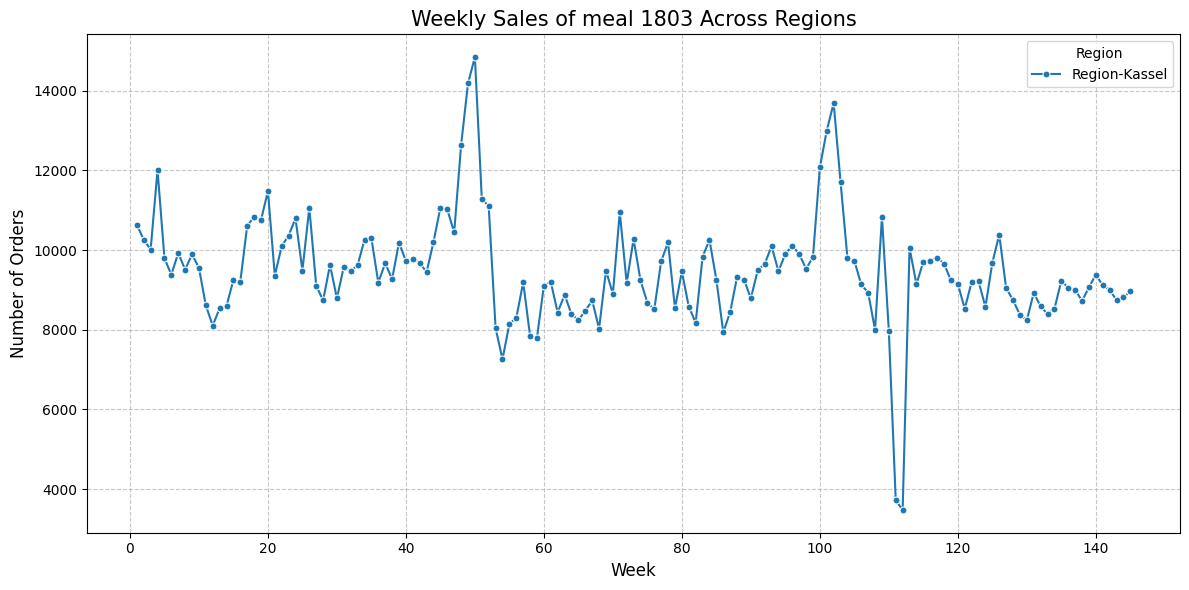

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the meal_id for Chicken Curry
#this_id = meals_df[meals_df['name'] == 'Chicken Curry']['meal_id'].iloc[0]
this_id = 1803
# Create a figure with appropriate size
plt.figure(figsize=(12, 6))

# Create empty DataFrames to store weekly sales data for each region
weekly_sales = []

# Loop through each region and get the weekly data for Chicken Curry
for region in regions:
    # Filter data for this region and for Chicken Curry
    region_meal_data = forecaster.train_data[
        (forecaster.train_data['region'] == region) & 
        (forecaster.train_data['meal_id'] == this_id)
    ]
    
    # Group by week and sum the number of orders
    weekly_data = region_meal_data.groupby('week')['num_orders'].sum().reset_index()
    weekly_data['region'] = region
    
    # Append to our list
    weekly_sales.append(weekly_data)

# Combine all regions' data
all_regions_data = pd.concat(weekly_sales)

# Create the plot
sns.lineplot(data=all_regions_data, x='week', y='num_orders', hue='region', marker='o', markersize=5)

# Add labels and title
plt.title(f'Weekly Sales of meal {this_id} Across Regions', fontsize=15)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Improve legend
plt.legend(title='Region', fontsize=10)


# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [ ]:
chicken_curry_id

np.int64(1778)

### XYZ-Analyse

In [ ]:
def berechne_variationskoeffizient(zeitreihe):
    # Standardabweichung berechnen
    std = np.std(zeitreihe, ddof=1)  # ddof=1 für Stichprobe
    
    # Mittelwert berechnen
    mittelwert = np.mean(zeitreihe)
    
    # Variationskoeffizient berechnen
    v = (std / mittelwert) * 100 if mittelwert != 0 else float('inf')
    
    return v

def xyz_klassifizierung(variationskoeffizient):
    if variationskoeffizient <= 10:
        return 'X'
    elif variationskoeffizient <= 25:
        return 'Y'
    else:
        return 'Z'

In [ ]:
unique_meal_ids = forecaster.train_data['meal_id'].unique()

for meal_id in unique_meal_ids:

    xyz_id = meal_id  # Chicken Curry meal ID
    print(f"\nXYZ-Analyse für Meal ID: {xyz_id}, {meals_df['name'][meals_df['meal_id'] == xyz_id].values[0]}")
    # XYZ-Analyse für Chicken Curry nach Regionen
    for region in regions:
        # Daten für Chicken Curry in dieser Region extrahieren
        region_data = forecaster.train_data[
            (forecaster.train_data['region'] == region) & 
            (forecaster.train_data['meal_id'] == xyz_id)
        ]
        #print(region_data.head())
        
        # Für bessere Analyse nach Wochen gruppieren
        weekly_data = region_data.groupby('week')['num_orders'].sum().reset_index()
        #print(f"Weekly data for {region}:\n{weekly_data.head()}")
        # Variationskoeffizient berechnen
        v = berechne_variationskoeffizient(weekly_data['num_orders'])
        
        # XYZ-Kategorie bestimmen
        kategorie = xyz_klassifizierung(v)
        
        print(f"Region: {region}")
        print(f"  - Variationskoeffizient: {v:.2f}%")
        print(f"  - XYZ-Kategorie: {kategorie}")
        print(f"  - Durchschnitt pro Woche: {weekly_data['num_orders'].mean():.2f}")


XYZ-Analyse für Meal ID: 1885, Basic Vegetable Pasta Bake
Region: Region-Kassel
  - Variationskoeffizient: 18.57%
  - XYZ-Kategorie: Y
  - Durchschnitt pro Woche: 32641.46
Region: Region-Luzern
  - Variationskoeffizient: 27.11%
  - XYZ-Kategorie: Z
  - Durchschnitt pro Woche: 8586.83
Region: Region-Wien
  - Variationskoeffizient: 31.89%
  - XYZ-Kategorie: Z
  - Durchschnitt pro Woche: 7609.15

XYZ-Analyse für Meal ID: 1993, Simple Spinach and Chickpea Curry
Region: Region-Kassel
  - Variationskoeffizient: 23.93%
  - XYZ-Kategorie: Y
  - Durchschnitt pro Woche: 24712.56
Region: Region-Luzern
  - Variationskoeffizient: 28.52%
  - XYZ-Kategorie: Z
  - Durchschnitt pro Woche: 7832.99
Region: Region-Wien
  - Variationskoeffizient: 31.42%
  - XYZ-Kategorie: Z
  - Durchschnitt pro Woche: 7982.93

XYZ-Analyse für Meal ID: 2539, Basic Tofu Stir Fry
Region: Region-Kassel
  - Variationskoeffizient: 31.75%
  - XYZ-Kategorie: Z
  - Durchschnitt pro Woche: 13702.41
Region: Region-Luzern
  - Variati

### Pseudocode

In [ ]:
predicted_Menge = 0
forecast_Menge = 0
zutaten = []
einkaufskosten = 0
lagerkosten = 0
opportunitätskosten = 0
penalty_cost = 0

In [ ]:
differenzmenge = predicted_Menge - forecast_Menge

if differenzmenge > 0:  # Overprediction
    for zutat in zutaten:
        if zutat.is_perishable:
            penalty_cost += einkaufskosten
            penalty_cost += (lagerkosten + opportunitätskosten)
        else:
            penalty_cost += (lagerkosten + opportunitätskosten)

elif differenzmenge < 0:  # Underprediction
    penalty_cost += (einkaufskosten * 1.5)
